In [1]:
# loading in and transforming data
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,ConcatDataset
from torch.autograd import Variable
from torch.nn.utils import prune
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#from skimage import io, transform
from PIL import Image

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

# load dataset information
import yaml

# image writing
import imageio
from skimage import img_as_ubyte

# Clear GPU cache
torch.cuda.empty_cache()

In [2]:
# configuration
WholeDatasetName = 'UTTQ'
#WholeDatasetName = 'Kvasir'

model_type = 'B0'
_model_name = 'ESFP_{}_Endo_{}'.format(model_type,WholeDatasetName)
config = open('Configure.yaml')
config = yaml.safe_load(config)

init_trainsize = 352
batch_size = 8

repeats = 1
n_epochs = 200
if_renew = True

In [3]:
class SplittingDataset(Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_root, gt_root):

        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpeg') or f.endswith('.png')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.png') or f.endswith('.jpeg')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.filter_files()
        self.size = len(self.images)
        self.transform = transforms.ToTensor()

    def __getitem__(self, index):
        
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        name = self.images[index].split('/')[-1]
        return self.transform(image), self.transform(gt), name

    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def __len__(self):
        return self.size

In [4]:
# def devide_into_4_parts(image, gt):
#     h, w = image.size()[2], image.size()[3]
#     # print(h, w, type(image), type(gt), image.shape, gt.shape)
#     sub_h = h // 2
#     sub_w = w // 2

#     # Create sub-images and sub-gts
#     sub_images = [
#         image[:, :, :sub_h, :sub_w],
#         image[:, :, :sub_h, sub_w:],
#         image[:, :, sub_h:, :sub_w],
#         image[:, :, sub_h:, sub_w:]
#     ]

#     sub_gts = [
#         gt[:,:, :sub_h, :sub_w],
#         gt[:,:, :sub_h, sub_w:],
#         gt[:,:, sub_h:, :sub_w],
#         gt[:,:, sub_h:, sub_w:]
#     ]
#     return sub_images, sub_gts
def splitDataset(renew, root_dir):
    
    split_train_images_save_path = './Endoscope-WL/{}_Splited/trainSplited/images'.format(WholeDatasetName)
    os.makedirs(split_train_images_save_path, exist_ok=True)
    split_train_masks_save_path = './Endoscope-WL/{}_Splited/trainSplited/masks'.format(WholeDatasetName)
    os.makedirs(split_train_masks_save_path, exist_ok=True)
    
    split_validation_images_save_path = './Endoscope-WL/{}_Splited/validationSplited/images'.format(WholeDatasetName)
    os.makedirs(split_validation_images_save_path, exist_ok=True)
    split_validation_masks_save_path = './Endoscope-WL/{}_Splited/validationSplited/masks'.format(WholeDatasetName)
    os.makedirs(split_validation_masks_save_path, exist_ok=True)
    
    split_test_images_save_path = './Endoscope-WL/{}_Splited/testSplited/images'.format(WholeDatasetName)
    os.makedirs(split_test_images_save_path, exist_ok=True)
    split_test_masks_save_path = './Endoscope-WL/{}_Splited/testSplited/masks'.format(WholeDatasetName)
    os.makedirs(split_test_masks_save_path, exist_ok=True)
    
    if renew == True:
    
        DatasetList = []
        
        # images_train_path = config['dataset']['train_' + str(WholeDatasetName) + '_dataset'] + '/images/'
        images_train_path = root_dir + "/new_train/images/"
        # masks_train_path = config['dataset']['train_' + str(WholeDatasetName) + '_dataset'] + '/masks/'
        masks_train_path = root_dir + "/new_train/mask_images/"
        print(len(os.listdir(images_train_path)))
        print(len(os.listdir(masks_train_path)))
        Dataset_part_train = SplittingDataset(images_train_path, masks_train_path)
        DatasetList.append(Dataset_part_train)
         # images_test_path = config['dataset']['test_' + str(WholeDatasetName) + '_img']
        images_val_path = root_dir + "/new_valid/images/"
        # # masks_test_path = config['dataset']['test_' + str(WholeDatasetName) + '_label']
        masks_val_path = root_dir + "/new_valid/mask_images/"
        Dataset_part_val = SplittingDataset(images_val_path, masks_val_path)
        DatasetList.append(Dataset_part_val)

        # images_test_path = config['dataset']['test_' + str(WholeDatasetName) + '_img']
        images_test_path = root_dir + "/new_test/images/"
        # # masks_test_path = config['dataset']['test_' + str(WholeDatasetName) + '_label']
        masks_test_path = root_dir + "/new_test/mask_images/"
        Dataset_part_test = SplittingDataset(images_test_path, masks_test_path)
        DatasetList.append(Dataset_part_test)
                                    
        wholeDataset = ConcatDataset([DatasetList[0], DatasetList[1], DatasetList[2]])
        # val_num = int(0.1*len(wholeDataset))
        # test_num = int(0.1*len(wholeDataset))
                                    
        # train_num = len(wholeDataset) - val_num - test_num
        val_num = len(os.listdir(root_dir + "/new_valid/images/"))
        # print(val_num)
        # test_num = len(os.listdir(root_dir + "/new_test/images/"))
        train_num = len(os.listdir(root_dir + "/new_train/images/"))
        # print(train_num)
        
        # train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wholeDataset, [train_num, val_num, test_num])
        train_dataset = torch.utils.data.Subset(wholeDataset, range(train_num))
        val_dataset = torch.utils.data.Subset(wholeDataset, range(train_num, train_num + val_num))
        test_dataset = torch.utils.data.Subset(wholeDataset, range(train_num + val_num, len(wholeDataset)))
                           
        train_loader = DataLoader(dataset=train_dataset,batch_size=1,shuffle=False)
        val_loader = DataLoader(dataset=val_dataset,batch_size=1,shuffle=False)
        test_loader = DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)
    
        iter_train = iter(train_loader)
        for i in range(len(train_loader)):
            image, gt, name = iter_train.next()
            image_data = image.data.cpu().numpy().squeeze().transpose(1,2,0)
            gt_data = gt.data.cpu().numpy().squeeze()
            imageio.imwrite(split_train_images_save_path + '/' + name[0],img_as_ubyte(image_data))
            imageio.imwrite(split_train_masks_save_path + '/' + name[0],img_as_ubyte(gt_data))
            
        iter_val = iter(val_loader)
        for i in range(len(val_loader)):
            image, gt, name = iter_val.next()
            image_data = image.data.cpu().numpy().squeeze().transpose(1,2,0)
            gt_data = gt.data.cpu().numpy().squeeze()
            imageio.imwrite(split_validation_images_save_path + '/' + name[0],img_as_ubyte(image_data))
            imageio.imwrite(split_validation_masks_save_path + '/' + name[0],img_as_ubyte(gt_data))
            
        
        iter_test = iter(test_loader)
        for i in range(len(test_loader)):
            image, gt, name = iter_test.next()
            image_data = image.data.cpu().numpy().squeeze().transpose(1,2,0)
            gt_data = gt.data.cpu().numpy().squeeze()
            imageio.imwrite(split_test_images_save_path + '/' + name[0],img_as_ubyte(image_data))
            imageio.imwrite(split_test_masks_save_path + '/' + name[0],img_as_ubyte(gt_data))        
    
    return split_train_images_save_path, split_train_masks_save_path, split_validation_images_save_path, split_validation_masks_save_path, split_test_images_save_path, split_test_masks_save_path

In [5]:
if_renew = False
root_dir = "/home/baoanh/baoanh/DATN/dataset/Ungthuthucquan"
train_images_path, train_masks_path, val_images_path, val_masks_path, test_images_path, test_masks_path = splitDataset(if_renew, root_dir)

In [6]:
# root_path  = "/home/baoanh/baoanh/DATN/ESFPNet/Endoscope-WL/UTTQ_Splited_original/"
# train_images_path = root_path + "trainSplited/images"
# train_masks_path = root_path + "trainSplited/masks"
# val_images_path = root_path + "validationSplited/images"
# val_masks_path = root_path + "validationSplited/masks"
# test_images_path = root_path + "testSplited/images"
# test_masks_path = root_path + "testSplited/masks"

In [7]:
class PolypDataset(Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_root, gt_root, trainsize, augmentations):
        self.trainsize = trainsize
        self.augmentations = augmentations
        # print(self.augmentations)
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpeg') or f.endswith('.png')]
        #print(image_root)
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.png') or f.endswith('.jpeg')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.filter_files()
        self.size = len(self.images)
        if self.augmentations == True:
            print('Using RandomRotation, RandomFlip')
            self.img_transform = transforms.Compose([
                transforms.RandomRotation(90, resample=False, expand=False, center=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0, hue=0),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
            self.gt_transform = transforms.Compose([
                transforms.RandomRotation(90, resample=False, expand=False, center=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
            
        else:
            print('no augmentation')
            self.img_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
            
            self.gt_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
            

    def __getitem__(self, index):
        
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        np.random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.img_transform is not None:
            image = self.img_transform(image)
            
        np.random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.gt_transform is not None:
            gt = self.gt_transform(gt)
        return image, gt

    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            # return img.convert('1')
            return img.convert('L')

    def resize(self, img, gt):
        assert img.size == gt.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def __len__(self):
        return self.size

class test_dataset:
    def __init__(self, image_root, gt_root, testsize):
        self.testsize = testsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpeg') or f.endswith('.png')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.tif') or f.endswith('.png') or f.endswith('.jpeg')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.ToTensor()
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        image = self.transform(image).unsqueeze(0)
        gt = self.binary_loader(self.gts[self.index])
        name = self.images[self.index].split('/')[-1]
        if name.endswith('.jpg'):
            name = name.split('.jpg')[0] + '.png'
        self.index += 1
        return image, gt, name

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

In [8]:
from Encoder import mit
from Decoder import mlp
from mmcv.cnn import ConvModule

class ESFPNetStructure(nn.Module):

    def __init__(self, embedding_dim = 160):
        super(ESFPNetStructure, self).__init__()
        
        # Backbone
        if model_type == 'B0':
            self.backbone = mit.mit_b0()
        if model_type == 'B1':
            self.backbone = mit.mit_b1()
        if model_type == 'B2':
            self.backbone = mit.mit_b2()
        if model_type == 'B3':
            self.backbone = mit.mit_b3()
        if model_type == 'B4':
            self.backbone = mit.mit_b4()
        if model_type == 'B5':
            self.backbone = mit.mit_b5()
        self.l1_lambda = 1e-6
        self.l2_lambda = 1e-3
        self._init_weights()  # load pretrain
        
        # LP Header
        self.LP_1 = mlp.LP(input_dim = self.backbone.embed_dims[0], embed_dim = self.backbone.embed_dims[0])
        self.LP_2 = mlp.LP(input_dim = self.backbone.embed_dims[1], embed_dim = self.backbone.embed_dims[1])
        self.LP_3 = mlp.LP(input_dim = self.backbone.embed_dims[2], embed_dim = self.backbone.embed_dims[2])
        self.LP_4 = mlp.LP(input_dim = self.backbone.embed_dims[3], embed_dim = self.backbone.embed_dims[3])
        
        # Linear Fuse
        self.linear_fuse34 = ConvModule(in_channels=(self.backbone.embed_dims[2] + self.backbone.embed_dims[3]), out_channels=self.backbone.embed_dims[2], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        self.linear_fuse23 = ConvModule(in_channels=(self.backbone.embed_dims[1] + self.backbone.embed_dims[2]), out_channels=self.backbone.embed_dims[1], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        self.linear_fuse12 = ConvModule(in_channels=(self.backbone.embed_dims[0] + self.backbone.embed_dims[1]), out_channels=self.backbone.embed_dims[0], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        
        # Fused LP Header
        self.LP_12 = mlp.LP(input_dim = self.backbone.embed_dims[0], embed_dim = self.backbone.embed_dims[0])
        self.LP_23 = mlp.LP(input_dim = self.backbone.embed_dims[1], embed_dim = self.backbone.embed_dims[1])
        self.LP_34 = mlp.LP(input_dim = self.backbone.embed_dims[2], embed_dim = self.backbone.embed_dims[2])
        
        # Final Linear Prediction
        self.linear_pred = nn.Conv2d((self.backbone.embed_dims[0] + self.backbone.embed_dims[1] + self.backbone.embed_dims[2] + self.backbone.embed_dims[3]), 1, kernel_size=1)
        
    def _init_weights(self):
        
        if model_type == 'B0':
            pretrained_dict = torch.load('./Pretrained/mit_b0.pth')
        if model_type == 'B1':
            pretrained_dict = torch.load('./Pretrained/mit_b1.pth')
        if model_type == 'B2':
            pretrained_dict = torch.load('./Pretrained/mit_b2.pth')
        if model_type == 'B3':
            pretrained_dict = torch.load('./Pretrained/mit_b3.pth')
        if model_type == 'B4':
            pretrained_dict = torch.load('./Pretrained/mit_b4.pth')
        if model_type == 'B5':
            pretrained_dict = torch.load('./Pretrained/mit_b5.pth')
            
            
        model_dict = self.backbone.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.backbone.load_state_dict(model_dict)
        print("successfully loaded!!!!")
        
    # def l1_regularization_loss(self):
    #     l1_loss = 0.0
    #     # print(self.parameters())
    #     for param in self.parameters():
    #         # print(param)
    #         l1_loss += torch.sum(torch.abs(param))
    #     return self.l1_lambda * l1_loss  
    
    # def l2_regularization_loss(self):
    #     l2_loss = 0.0
    #     for param in self.parameters():
    #         l2_loss += torch.sum(param ** 2)
    #     return 0.5 * self.l2_lambda * l2_loss
    # def smooth_lasso_regularization_loss(self):
    #     smooth_lasso_loss = 0.0
    #     # print(self.parameters())
    #     for param in self.parameters():
    #         # print(param)
    #         if torch.sum(torch.abs(param)) < 1:
    #             smooth_lasso_loss += 0.5*torch.sum(param ** 2)
    #         else:
    #             smooth_lasso_loss += torch.sum(torch.abs(param)) - 0.5
    #     return self.l1_lambda * smooth_lasso_loss
    def forward(self, x):
        
        ##################  Go through backbone ###################
        
        B = x.shape[0]
        
        #stage 1
        out_1, H, W = self.backbone.patch_embed1(x)
        for i, blk in enumerate(self.backbone.block1):
            out_1 = blk(out_1, H, W)
        out_1 = self.backbone.norm1(out_1)
        out_1 = out_1.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[0], 88, 88)
        
        # stage 2
        out_2, H, W = self.backbone.patch_embed2(out_1)
        for i, blk in enumerate(self.backbone.block2):
            out_2 = blk(out_2, H, W)
        out_2 = self.backbone.norm2(out_2)
        out_2 = out_2.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[1], 44, 44)
        
        # stage 3
        out_3, H, W = self.backbone.patch_embed3(out_2)
        for i, blk in enumerate(self.backbone.block3):
            out_3 = blk(out_3, H, W)
        out_3 = self.backbone.norm3(out_3)
        out_3 = out_3.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[2], 22, 22)
        
        # stage 4
        out_4, H, W = self.backbone.patch_embed4(out_3)
        for i, blk in enumerate(self.backbone.block4):
            out_4 = blk(out_4, H, W)
        out_4 = self.backbone.norm4(out_4)
        out_4 = out_4.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[3], 11, 11)
        
        # go through LP Header
        lp_1 = self.LP_1(out_1)
        lp_2 = self.LP_2(out_2)  
        lp_3 = self.LP_3(out_3)  
        lp_4 = self.LP_4(out_4)
        
        # linear fuse and go pass LP Header
        lp_34 = self.LP_34(self.linear_fuse34(torch.cat([lp_3, F.interpolate(lp_4,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        lp_23 = self.LP_23(self.linear_fuse23(torch.cat([lp_2, F.interpolate(lp_34,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        lp_12 = self.LP_12(self.linear_fuse12(torch.cat([lp_1, F.interpolate(lp_23,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        
        # get the final output
        lp4_resized = F.interpolate(lp_4,scale_factor=8,mode='bilinear', align_corners=False)
        lp3_resized = F.interpolate(lp_34,scale_factor=4,mode='bilinear', align_corners=False)
        lp2_resized = F.interpolate(lp_23,scale_factor=2,mode='bilinear', align_corners=False)
        lp1_resized = lp_12
        
        out = self.linear_pred(torch.cat([lp1_resized, lp2_resized, lp3_resized, lp4_resized], dim=1))
        
        return out

In [9]:
import torch
import torch.nn.functional as F

# def focal_loss(pred, mask, gamma=2, alpha=0.25):
#     # Calculate BCE Loss
#     # bce = F.binary_cross_entropy_with_logits(pred, mask, reduction='none')

#     # # Calculate the modulating factor
#     # p_t = torch.exp(-bce)
#     # modulating_factor = (1 - p_t) ** gamma

#     # # Calculate the Focal Loss
    
#     # focal_loss = modulating_factor * bce

#     # # Calculate the weighted focal loss
#     # weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=15, stride=1, padding=7) - mask)
#     # weighted_focal_loss = (weit * focal_loss).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))
#     # # print("weighted_focal_loss: ", weighted_focal_loss)
#     # return weighted_focal_loss.mean()
#     mask = mask.float()
#     pt = torch.sigmoid(pred) * mask + (1 - torch.sigmoid(pred)) * (1 - mask)
#     loss = -alpha * (1 - pt).pow(gamma) * torch.log(pt + 1e-12) - (1 - alpha) * pt.pow(gamma) * torch.log(1 - pt + 1e-12)

#     return loss.sum()

def focal_loss(pred, target, gamma=2, alpha=0.25, smooth=0.0001):
    num = target.size(0)
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice_coefficient = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)

    # Calculate the focal weights for each pixel
    focal_weights = torch.pow(1 - dice_coefficient, gamma)

    # Calculate the focal loss (element-wise multiplication with alpha)
    focal_loss = -alpha * torch.log(dice_coefficient) * focal_weights

    return focal_loss.sum() / num
def ange_structure_loss(pred, mask, smooth=1):
    
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=15, stride=1, padding=7) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduction='mean')
    wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + smooth)/(union - inter + smooth)

    wfocal = focal_loss(pred, mask) 

    # return (wbce+wiou).mean()
    return (wiou + wfocal + wbce).mean()

def dice_loss_coff(pred, target, smooth = 0.0001):
    
    num = target.size(0)
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return loss.sum()/num
def tversky_loss(pred, target, alpha=0.7, beta=0.3, smooth=0.0001):
    num = target.size(0)
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    false_positive = (pred * (1 - target)).sum(dim=2).sum(dim=2)
    false_negative = ((1 - pred) * target).sum(dim=2).sum(dim=2)
    
    tversky = (intersection + smooth) / (intersection + alpha * false_positive + beta * false_negative + smooth)
    loss = 1 - tversky
    
    return loss.sum() / num


In [10]:
from torch.autograd import Variable
def evaluate():  
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ESFPNet.eval()
    
    val = 0
    count = 0

    smooth = 1e-4
    
    val_loader = test_dataset(val_images_path + '/',val_masks_path + '/', init_trainsize)
    for i in range(val_loader.size):
        image, gt, name = val_loader.load_data()
        gt = np.asarray(gt, np.float32)
        gt /= (gt.max() + 1e-8)

        image = image.cuda()
        
        pred= ESFPNet(image)
        pred = F.upsample(pred, size=gt.shape, mode='bilinear', align_corners=False)
        pred = pred.sigmoid()
        threshold = torch.tensor([0.5]).to(device)
        pred = (pred > threshold).float() * 1

        pred = pred.data.cpu().numpy().squeeze()
        pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        
        target = np.array(gt)
        
        input_flat = np.reshape(pred,(-1))
        target_flat = np.reshape(target,(-1))
 
        intersection = (input_flat*target_flat)
        
        loss =  (2 * intersection.sum() + smooth) / (pred.sum() + target.sum() + smooth)

        a =  '{:.4f}'.format(loss)
        a = float(a)
        
        val = val + a
        count = count + 1
        
    ESFPNet.train()
    
    return val/count, loss

In [11]:
# def count_non_zero_parameters(model):
#     total_non_zero_params = 0
#     for param in model.parameters():
#         total_non_zero_params += torch.sum(param != 0).item()
#     return total_non_zero_params

In [12]:
# train the network
def training_loop(n_epochs,model, ESFPNet_optimizer, numIters):
    
    # keep track of losses over time
    losses = []
    val_losses = []
    coeff_max = 0
    
    # set up data and then train
    trainDataset = PolypDataset(train_images_path + '/', train_masks_path + '/', trainsize=init_trainsize, augmentations = True)
    train_loader = DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
    
    iter_X = iter(train_loader)
    steps_per_epoch = len(iter_X)
    num_epoch = 0
    total_steps = (n_epochs+1)*steps_per_epoch
    num_to_stop = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for step in range(1, total_steps):

        # Reset iterators for each epoch
        if step % steps_per_epoch == 0:
            iter_X = iter(train_loader)
            num_epoch = num_epoch + 1
        
        # make sure to scale to a range -1 to 1
        images, masks = iter_X.next()
        
        # move images to GPU if available (otherwise stay on CPU)
        images = images.to(device)
        masks = masks.to(device)


        # ============================================
        #            TRAIN THE NETWORKS
        # ============================================
       
        ESFPNet_optimizer.zero_grad()
        
        # 1. Compute the losses from the network
        
        out = ESFPNet(images)
        out = F.interpolate(out, scale_factor=4, mode='bilinear', align_corners=False)
        l1_regularization_strength = 1e-3
        loss = ange_structure_loss(out, masks)
        # print("Loss: ", loss.item())
        device = torch.device("cuda:0")
        # l1_reg = torch.tensor(0.0).to(device)
        # for module in model.modules():
        #     # mask = None
        #     # weight = None
        #     # for name, buffer in module.named_buffers():
        #     #     if name == "weight_mask":
        #     #         mask = buffer
        #     for name, param in module.named_parameters():
        #         if name == "weight_orig":
        #             # weight = param
        #             l1_reg += torch.norm(param, 1)
        #     # We usually only want to introduce sparsity to weights and prune weights.
        #     # Do the same for bias if necessary.
        #     # if mask is not None and weight is not None:
        #     #     l1_reg += torch.norm(mask * weight, 1)
        
        # loss += l1_regularization_strength * l1_reg 
        # loss += model.l1_regularization()  
    
        loss.backward()
        ESFPNet_optimizer.step() 
        
        # ============================================
        #            TRAIN THE NETWORKS
        # ============================================
        # Print the log info
        if step % steps_per_epoch == 0:
            
            losses.append(loss.item())
            print('Epoch [{:5d}/{:5d}] | preliminary loss: {:6.6f} '.format(num_epoch, n_epochs, loss.item()))
            
        if step % steps_per_epoch == 0:
            
            validation_coeff, val_loss = evaluate()
            val_losses.append(val_loss.item())
            print('Epoch [{:5d}/{:5d}] | validation_coeffient: {:6.6f} '.format(
                    num_epoch, n_epochs, validation_coeff))
            
            if coeff_max < validation_coeff:
                coeff_max = validation_coeff
                save_model_path = './SaveModel/{}_LA_{:1d}'.format(_model_name,numIters)
                os.makedirs(save_model_path, exist_ok=True)
                # print(save_model_path)
                torch.save(ESFPNet, save_model_path + '/ESFPNet.pt')
                print('Save Learning Ability Optimized Model at Epoch [{:5d}/{:5d}]'.format(num_epoch, n_epochs))
                num_to_stop = 0
            else:
                num_to_stop = num_to_stop + 1
    
        if num_to_stop >=10:
            break
    return losses, val_losses, coeff_max, num_epoch

In [13]:
def saveResult(numIters):
    
    save_path = './results/{}_LA_{:1d}/{}_Splited/'.format(_model_name,numIters,str(WholeDatasetName))
    os.makedirs(save_path, exist_ok=True)
    print(save_path)
    device = torch.device("cuda:0")    
    model_path =  './SaveModel/{}_LA_{:1d}'.format(_model_name,numIters)
    ESFPNetBest = torch.load(model_path + '/ESFPNet.pt')
    ESFPNetBest.eval()
    
    test_loader = test_dataset(test_images_path + '/', test_masks_path + '/', init_trainsize)
    for i in range(test_loader.size):
        image, gt, name = test_loader.load_data()
        gt = np.asarray(gt, np.float32)
        gt /= (gt.max() + 1e-8)
        image = image.cuda()

        pred = ESFPNetBest(image)
        pred = F.interpolate(pred, size=gt.shape, mode='bilinear', align_corners=False)
        pred = pred.sigmoid()
        threshold = torch.tensor([0.5]).to(device)
        pred = (pred > threshold).float() * 1
        pred = pred.data.cpu().numpy().squeeze()
        pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        
        imageio.imwrite(save_path+name,img_as_ubyte(pred))

In [14]:
# ESFPNet = ESFPNetStructure()
# print(ESFPNet)
# # def count_parameters(model):
# #     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# # # Example usage:
# # model = ESFPNetStructure()  # Initialize your model
# # total_params = count_parameters(model)
# # print(f"Total trainable parameters: {total_params}")

successfully loaded!!!!
Models moved to GPU.
#####################################################################################
Using RandomRotation, RandomFlip


/home/baoanh/miniconda3/envs/esfp/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


Epoch [    1/  200] | preliminary loss: 0.856788 


/home/baoanh/miniconda3/envs/esfp/lib/python3.10/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch [    1/  200] | validation_coeffient: 0.720655 
Save Learning Ability Optimized Model at Epoch [    1/  200]
Epoch [    2/  200] | preliminary loss: 0.835259 
Epoch [    2/  200] | validation_coeffient: 0.762238 
Save Learning Ability Optimized Model at Epoch [    2/  200]
Epoch [    3/  200] | preliminary loss: 0.591232 
Epoch [    3/  200] | validation_coeffient: 0.763592 
Save Learning Ability Optimized Model at Epoch [    3/  200]
Epoch [    4/  200] | preliminary loss: 0.668249 
Epoch [    4/  200] | validation_coeffient: 0.773958 
Save Learning Ability Optimized Model at Epoch [    4/  200]
Epoch [    5/  200] | preliminary loss: 0.421251 
Epoch [    5/  200] | validation_coeffient: 0.794489 
Save Learning Ability Optimized Model at Epoch [    5/  200]
Epoch [    6/  200] | preliminary loss: 0.643413 
Epoch [    6/  200] | validation_coeffient: 0.796374 
Save Learning Ability Optimized Model at Epoch [    6/  200]
Epoch [    7/  200] | preliminary loss: 0.967525 
Epoch [   

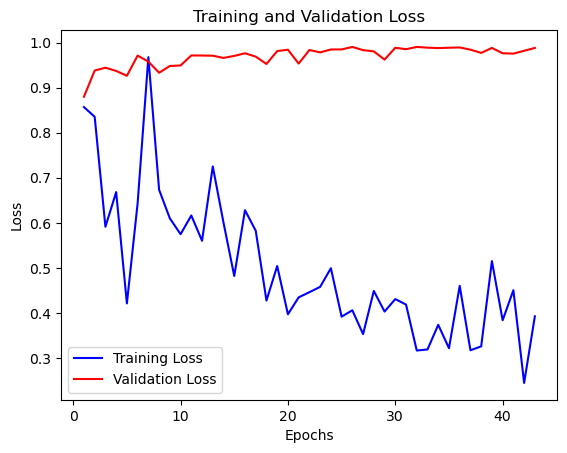

In [15]:
import torch.optim as optim
def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity
for i in range(repeats):
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    ESFPNet = ESFPNetStructure()
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        ESFPNet.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')
    print('#####################################################################################')  
    # for module_name, module in ESFPNet.named_modules():
    #     # print(module_name)
    #     if isinstance(module, torch.nn.Conv2d):
    #         #--conv2d_prune_amount
    #         # prune.l1_unstructured(
    #         #             module, name="weight", amount=0.01
    #         # )
    #         pass
    #     elif "LP" in module_name and isinstance(module, torch.nn.Linear):
    #         #--linear_prune_amount
    #         prune.l1_unstructured(
    #                     module, name="weight", amount=0.2
    #         )
    # num_zeros, num_elements, sparsity = measure_global_sparsity(
    #         ESFPNet, weight=True, bias=False, linear_use_mask=False
    #     )
    # print(f"Model sparsity at first: {sparsity}")
    # hyperparams for Adam optimizer
    lr=0.0001 #0.0001

    ESFPNet_optimizer = optim.AdamW(ESFPNet.parameters(), lr=lr)

    
    losses, val_losses, coeff_max, num_epoch = training_loop(n_epochs,ESFPNet, ESFPNet_optimizer, i+1)
    # num_zeros, num_elements, sparsity = measure_global_sparsity(
    #     ESFPNet, weight=True, bias=False, conv2d_use_mask=True, linear_use_mask=False
    # )
    # print(f"Model sparsity at last: {sparsity}")
    plt.plot(range(1, num_epoch+1), losses, color='b', label='Training Loss')
    plt.plot(range(1, num_epoch+1), val_losses, color='r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    print('#####################################################################################')  
    print('optimize_m_dice: {:6.6f}'.format(coeff_max))
    plt.savefig(f"visualize_{str(WholeDatasetName)}.png")
    saveResult(i+1)
    print('#####################################################################################')  
    print('saved the results')
    print('#####################################################################################')  
    

In [16]:
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix
from skimage import img_as_bool
from PIL import Image
# WholeDatasetName ="UTTQ"
# Paths to folders containing masks and predicted images
mask_folder = f"/home/baoanh/baoanh/DATN/ESFPNet/Endoscope-WL/{WholeDatasetName}_Splited/testSplited/masks"
# mask_folder = "/home/baoanh/baoanh/DATN/dataset/7 Loét HTT/new_test/mask_images"
predicted_folder = f"/home/baoanh/baoanh/DATN/ESFPNet/results/ESFP_B0_Endo_{WholeDatasetName}_LA_1/{WholeDatasetName}_Splited"
# predicted_folder = "/home/baoanh/baoanh/DATN/ESFPNet/results/ESFP_B0_Endo_UTTQ_LA_1/UTTQ_Splited"
# mask_folder = "/home/baoanh/baoanh/DATN/dataset/ViemdadayHpDuong/test/mask_images"
# List files in the folders
mask_files = os.listdir(mask_folder)
predicted_files = os.listdir(predicted_folder)
print(len(mask_files), len(predicted_files))
# Initialize lists to store true and predicted values
true_values = []
predicted_values = []

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp + 1e-6)
precision = 0
recall = 0
f1 = 0
iou = 0
specificity = 0
# Load and process masks and predicted images
for mask_file, pred_file in zip(mask_files, predicted_files):
    mask_path = os.path.join(mask_folder, mask_file)
    pred_path = os.path.join(predicted_folder, pred_file)
    
    # Load images as arrays (grayscale images)
    mask = np.array(Image.open(mask_path))
    pred = np.array(Image.open(pred_path))
    # print(mask.shape, pred.shape, np.unique(mask), np.unique(pred))
    # mask = np.array(mask)/255 > 0.5
    # pred = np.array(pred)/255 > 0.5
    mask = mask.flatten()
    pred = pred.flatten()
    true_values.extend(mask.flatten())
    predicted_values.extend(pred.flatten())
    # precision += precision_score(mask, pred)
    # recall += recall_score(mask, pred)
    # f1 += f1_score(mask, pred)
    # jaccard_indices = jaccard_score(mask, pred, average=None)
    # iou += np.mean(jaccard_indices)
    # specificity += specificity_score(mask, pred)
    
# # Convert lists to NumPy arrays
# print(np.unique(true_values))
# print(np.unique(predicted_values))
true_values = np.array(true_values)/255 > 0.5
predicted_values = np.array(predicted_values)/255 > 0.5
# print(np.unique(true_values))
# print(np.unique(predicted_values))
# # Calculate metrics
precision = precision_score(true_values, predicted_values)
recall = recall_score(true_values, predicted_values)
f1 = f1_score(true_values, predicted_values)
# conf_matrix = confusion_matrix(true_values, predicted_values)

# # Calculate mIoU (Jaccard Index)
jaccard_indices = jaccard_score(true_values, predicted_values, average=None)
miou = np.mean(jaccard_indices)

# # Calculate mDice (Dice Coefficient)
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    total = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (total + 1e-6)

mdice = dice_coef(true_values, predicted_values)

print("mDice:", np.mean(f1))
print("mIoU:",miou)
print("Recall:", np.mean(recall))
print("Precision:", np.mean(precision))

# # mspecificity = specificity_score(true_values, predicted_values)
# print("mDice:", np.mean(f1)/len(mask_files))
# print("mIoU:", np.mean(iou)/len(mask_files))
# print("Recall:", np.mean(recall)/len(mask_files))
# print("Precision:", np.mean(precision)/len(mask_files))
# # print("mSpecificity:", np.mean(specificity)/len(mask_files))


55 55
mDice: 0.8486395217793089
mIoU: 0.8137707401085194
Recall: 0.8210906904208645
Precision: 0.8781011397174372


In [17]:
#UTTQ:
'''
Before sparse:
ESFPNet [42] 0.8633 0.8291 0.8479 0.8794
Ours 0.8654 0.8332 0.8262 0.9084

Model sparsity at last: 0.12221343932085313
mDice: 0.740787410554658
mIoU: 0.7173545153715384
Recall: 0.8073570862473162
Precision: 0.7550762918005283


mDice: 0.8443018897407832
mIoU: 0.8181591820460904
Recall: 0.8579098010430998
Precision: 0.8559038959010904

'''

'\nBefore sparse:\nESFPNet [42] 0.8633 0.8291 0.8479 0.8794\nOurs 0.8654 0.8332 0.8262 0.9084\n\nModel sparsity at last: 0.12221343932085313\nmDice: 0.740787410554658\nmIoU: 0.7173545153715384\nRecall: 0.8073570862473162\nPrecision: 0.7550762918005283\n\n\nmDice: 0.8443018897407832\nmIoU: 0.8181591820460904\nRecall: 0.8579098010430998\nPrecision: 0.8559038959010904\n\n'

In [18]:
mDice: 0.8670030036500223
mIoU: 0.8273643762673336
Recall: 0.9062145795935481
Precision: 0.8622526422860325
mSpecificity: 0.9155333735236033
# Model sparsity at last: 0.12221343932085313

In [19]:
# import torch
# import torch.nn as nn
# class LP(nn.Module):
#     """
#     Linear Prediction
#     """
#     def __init__(self, input_dim=2048, embed_dim=768):
#         super().__init__()
#         self.proj = nn.Linear(input_dim, embed_dim)

#     def forward(self, x):
#         B,_,H,W = x.shape
#         print("Initial: ", x.shape)
#         x = x.flatten(2)
#         print("After flatten: ", x.shape)
#         x = x.transpose(1, 2)
#         print("After transpose: ", x.shape)
#         x = self.proj(x)
#         print("After linear: ", x.shape)
#         return x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

# # Tạo một mô hình LP với input_dim=2048 và embed_dim=768
# lp_model = LP(input_dim=2048, embed_dim=768)

# # Tạo một ví dụ đầu vào x với kích thước (B, C, H, W) (batch size, channels, height, width)
# input_x = torch.randn(8, 2048, 8, 8)  # Ví dụ với batch size là 8

# # Sử dụng mô hình LP để thực hiện dự đoán tuyến tính
# output = lp_model(input_x)

# # Kết quả là một tensor có kích thước (B, H, W, embed_dim)
# print(output.shape)  # In kích thước của đầu ra
# # embed_dims=[64, 128, 256, 512]
# tmp = nn.Conv2d(768, 1, kernel_size=1)(output)
# print(tmp.shape)
# # Lưu ý rằng đầu ra của mô hình LP có kích thước B x H x W x embed_dim,
# # trong đó B là batch size, H và W là chiều cao và chiều rộng của đầu vào,
# # và embed_dim là kích thước của embedding sau khi thực hiện linear projection.


In [20]:
# import torch.nn as nn
# import torch
# # Define a class for your model
# class LinearPredictionModel(nn.Module):
#     def __init__(self, embed_dims):
#         super(LinearPredictionModel, self).__init__()
        
#         # Calculate the input channels by summing up the embed_dims
#         input_channels = sum(embed_dims)
        
#         # Create a 1x1 Conv2d layer for linear prediction
#         self.linear_pred = nn.Conv2d(input_channels, 1, kernel_size=1)
    
#     def forward(self, x):
#         # Forward pass through the linear prediction layer
#         out = self.linear_pred(x)
#         return out

# # Example usage:
# # Assuming embed_dims is a list of embed dimensions [dim1, dim2, dim3, dim4]
# embed_dims = [64, 128, 256, 512]

# # Create an instance of the LinearPredictionModel
# model = LinearPredictionModel(embed_dims)

# # You can then use this model to perform linear predictions
# # For example, you can pass some input tensor x through the model
# # to get the predicted output:
# input_tensor = torch.randn(1, sum(embed_dims), 10, 10)  # Example input tensor
# print(input_tensor.shape)
# output = model(input_tensor)
# print(output.shape)
# # 'output' will contain the predicted output of the linear regression.
